In [49]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [50]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

In [51]:
DATASET_DIR = os.getcwd() + "\\chest-xraydataset\\"
meta_data = pd.read_csv(DATASET_DIR + "Chest_xray_Corona_Metadata.csv",header=0, index_col=0)

In [52]:
train_df = meta_data.loc[meta_data['Dataset_type'] == 'TRAIN']
test_df = meta_data.loc[meta_data['Dataset_type'] == 'TEST']

val_df = train_df.sample(frac=0.2)
train_df = train_df.sample(frac=0.8)

len_train = train_df.shape[0]
len_val =val_df.shape[0]
len_test = test_df.shape[0]

In [53]:
# array com as imagens
x_train = np.zeros((len_train,125,125,3), float)
y_train = np.zeros((len_train), float)
x_val = np.zeros((len_val,125,125,3), float)
y_val = np.zeros((len_val), float)
x_test = np.zeros((len_test,125,125,3), float)
y_test = np.zeros((len_test), float)

In [54]:
index=0
for row in train_df.iterrows():
    row = row[1]
    im = cv2.imread(f"{DATASET_DIR}train\\{row['X_ray_image_name']}")
    im_resized = cv2.resize(im, dsize=(125, 125), interpolation=cv2.INTER_CUBIC)
    x_train[index] = im_resized
    if row['Label'] != 'Normal':
        y_train[index] = 1
    index += 1

In [16]:
index=0
for row in val_df.iterrows():
    row = row[1]
    im = cv2.imread(f"{DATASET_DIR}train\\{row['X_ray_image_name']}")
    im_resized = cv2.resize(im, dsize=(125, 125), interpolation=cv2.INTER_CUBIC)
    x_val[index] = im_resized
    if row['Label'] != 'Normal':
        y_val[index] = 1
    index += 1

In [17]:
index=0
for row in test_df.iterrows():
    row = row[1]
    im = cv2.imread(f"{DATASET_DIR}test\\{row['X_ray_image_name']}")
    im_resized = cv2.resize(im, dsize=(125, 125), interpolation=cv2.INTER_CUBIC)
    x_test[index] = im_resized
    if row['Label'] != 'Normal':
        y_test[index] = 1
    index += 1

In [18]:
print(x_val.shape)
print(y_val.shape)

(1057, 125, 125, 3)
(1057,)


In [19]:
print(x_train.shape)
print(y_train.shape)

(4229, 125, 125, 3)
(4229,)


In [20]:
# normalização
x_test = x_test/255.0
x_train = x_train/255.0
x_val = x_val/255.0

In [44]:
# arquitetura da rede
i = Input(shape=x_train[0].shape)
# Convolução 
# Função de ativação
# 1o grupo
x = Conv2D(32,  (3,3), activation='relu', padding='same')(i)
x = Conv2D(32,  (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
#
# 2o grupo
x = Conv2D(128, (3,3), activation='relu', padding = 'same')(x)
x = Conv2D(128, (3,3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)
#
# 3o grupo
x = Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
x = Conv2D(256, (3,3), activation='relu', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)
#
# # Estágio Fully Connected (Dense)
# 
x = Flatten()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(i, x)

In [45]:
#opt = SGD(lr=0.01)
model.compile(loss = "binary_crossentropy", optimizer = Adam(lr=0.001), metrics=['accuracy'])

In [47]:
#Treinando com 20 épocas
result = model.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=1)

Train on 4229 samples, validate on 1057 samples
4229/4229 [==============================] - 573s 135ms/sample - loss: 0.1532 - accuracy: 0.9432 - val_loss: 0.0874 - val_accuracy: 0.9622


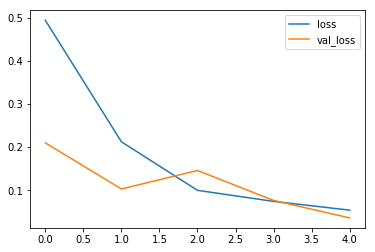

In [30]:
plt.plot(result.history['loss'], label='loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()

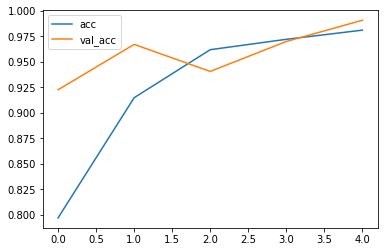

In [31]:
plt.plot(result.history['accuracy'], label='acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()

In [48]:
#descobrir por que sempre está recebendo sempre o mesmo resultado
p_test = model.predict(x_train).argmax(axis=1)
np.sum(p_test)

0

Text(0.5,1,'Rótulo Real: Pneumonia Previsão: Normal')

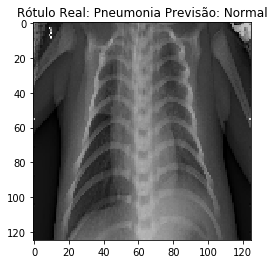

In [94]:
labels = '''Normal
Pneumonia'''.split()
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("Rótulo Real: %s Previsão: %s" % (labels[y_test[i]], labels[p_test[i]]))